# Preprocessing

In [3]:
!pip install soccerbars > /dev/null

In [1]:
import pandas as pd
import numpy as np

from soccerbars import soccerbar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
season_df = pd.read_csv("data/BAR_RMA_2023_understat/season_results.csv")

season_df['datetime'] = pd.to_datetime(season_df['datetime'])

# Filtering the DataFrame to include only records before October 28, 2023
season_df = season_df[season_df['datetime'] < pd.Timestamp('2023-10-28')]

# Filtering the DataFrame to include only matches involving Barcelona or Real Madrid
season_df = season_df[season_df['a.title'].isin(['Barcelona', 'Real Madrid']) | season_df['h.title'].isin(['Barcelona', 'Real Madrid'])]

season_df.head(5)

,Unnamed: 0,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l
4,4,22689,True,2023-08-12 19:30:00,147,Athletic Club,ATH,150,Real Madrid,RMA,0,2,0.700577,1.33266,0.1752,0.2983,0.5265
7,7,22692,True,2023-08-13 19:30:00,142,Getafe,GET,148,Barcelona,BAR,0,0,0.804505,1.67817,0.1521,0.2422,0.6057
13,13,22698,True,2023-08-19 17:30:00,208,Almeria,ALM,150,Real Madrid,RMA,1,3,1.813280,2.88020,0.1897,0.1959,0.6144
16,16,22701,True,2023-08-20 17:30:00,148,Barcelona,BAR,261,Cadiz,CAD,2,0,3.425240,1.11132,0.8494,0.1008,0.0498
21,21,22712,True,2023-08-25 19:30:00,152,Celta Vigo,CEL,150,Real Madrid,RMA,0,1,1.178270,1.61670,0.2391,0.2663,0.4946


In [3]:
# Extracting match results for Barcelona
result_bar_df = season_df[season_df['a.title'].isin(['Barcelona']) | season_df['h.title'].isin(['Barcelona'])].copy()

# Adding a column to indicate if Barcelona played at home
result_bar_df['is_home'] = False
result_bar_df['is_home'] = result_bar_df['h.title'] == 'Barcelona'
result_bar_df['is_away'] = ~result_bar_df['is_home']

# Calculating goals scored and missed for Barcelona in each match
result_bar_df['goals_scored'] = result_bar_df['is_home'] * result_bar_df['goals.h'] + ~result_bar_df['is_home'] * result_bar_df['goals.a']
result_bar_df['goals_missed'] = ~result_bar_df['is_home'] * result_bar_df['goals.h'] + result_bar_df['is_home'] * result_bar_df['goals.a']

# Extracting match results for Real Madrid
result_rma_df = season_df[season_df['a.title'].isin(['Real Madrid']) | season_df['h.title'].isin(['Real Madrid'])].copy()

# Adding a column to indicate if Real Madrid played at home
result_rma_df['is_home'] = False
result_rma_df['is_home'] = result_rma_df['h.title'] == 'Real Madrid'
result_rma_df['is_away'] = ~result_rma_df['is_home']

# Calculating goals scored and missed for Real Madrid in each match
result_rma_df['goals_scored'] = result_rma_df['is_home'] * result_rma_df['goals.h'] + ~result_rma_df['is_home'] * result_rma_df['goals.a']
result_rma_df['goals_missed'] = ~result_rma_df['is_home'] * result_rma_df['goals.h'] + result_rma_df['is_home'] * result_rma_df['goals.a']

# Matplotlib season history charts

In [11]:
# Helper funtions
def get_color(row):
    # draw
    if row['goals_scored'] == row['goals_missed']:
        return 'gray'
    if row['goals_scored'] > row['goals_missed']:
        return 'green'
    return 'red'

def set_color_mono(row, rect, face_color1, face_color2):
    rect.set_edgecolor('black')

    # draw
    if row['goals_scored'] == row['goals_missed']:
        rect.set_hatch("//")
        rect.set_facecolor(face_color2)
    elif row['goals_scored'] > row['goals_missed']:
        rect.set_facecolor(face_color1)
    else:
        rect.set_facecolor('lightgray')

def game_title(row):
    return f"{row['h.title']} - {row['a.title']} {row['goals.h']}:{row['goals.a']}"

In [39]:
def plot_matches_history(df, team='', edgecolor=None, face_color1=None, face_color2=None):
    # Generate x-axis values based on the length of the DataFrame
    x = range(len(df))
    
    # Create a figure and axis
    fig = plt.figure()
    ax = plt.subplot()
    
    goals_scored = df['goals_scored'].values
    goals_missed = df['goals_missed'].values

    # Set y-axis limits
    plt.ylim(-5, 5)
    
    # Create positive (goals scored) and negative (goals missed) bars
    bar_pos = ax.bar(x, goals_scored, width=0.6, color='g')
    bar_neg = ax.bar(x, -goals_missed, width=0.6, color='b')
    
    # Annotate bars with match titles and apply colors
    for rect, i in zip(bar_pos, np.arange(0, len(df))):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height + 0.2, game_title(df.iloc[i]), ha='center', va='bottom', rotation='vertical')
        if face_color1:
            set_color_mono(df.iloc[i], rect, face_color1, face_color2)
        else:
            rect.set_color(get_color(df.iloc[i]))
        
    for rect, i in zip(bar_neg, np.arange(0, len(df))):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height - 0.2, "Matchday "+str(i+1), ha='center', va='top', rotation='vertical')
        if face_color1:
            set_color_mono(df.iloc[i], rect, face_color1, face_color2)
        else:
            rect.set_color(get_color(df.iloc[i]))
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, linewidth=2, color='black')

    upper_line_y = [row['xG.h'] if row['h.title'] == team else row['xG.a'] for _, row in df.iterrows()]
    lower_line_y = [-row['xG.h'] if row['h.title'] != team else -row['xG.a'] for _, row in df.iterrows()]

    x = np.arange(0, len(upper_line_y))

    plt.plot(x, upper_line_y, linewidth=2, color='orange')
    plt.plot(x, lower_line_y, linewidth=2, color='orange')
    
    # Create legend patches based on face colors or default colors
    if face_color1:
        win_patch = mpatches.Patch(edgecolor='black', facecolor=face_color1, label='Win',)
        loss_patch = mpatches.Patch(edgecolor='black', facecolor='lightgray', label='Loss')
        draw_patch = mpatches.Patch(edgecolor='black', facecolor=face_color2, hatch="//", label='Draw')
    else:
        win_patch = mpatches.Patch(color='green', label='Win',)
        loss_patch = mpatches.Patch(color='red', label='Loss')
        draw_patch = mpatches.Patch(color='grey', label='Draw')
    
    # Add legend to the upper left of the plot
    ax.legend(handles=[win_patch, loss_patch, draw_patch], loc='upper left', bbox_to_anchor=(1, 1))
    
    # Customize plot appearance: remove top and right spines, hide x-axis ticks, set y-axis label
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    # Comment to hide y-axes
    ax.set_ylabel("Goals \nmissed/scored")
    
    # Uncomment the following lines to hide y-axes
    #ax.spines['left'].set_visible(False)
    #ax.get_yaxis().set_ticks([])

    # Set the title based on the team name
    command_name = df[df['is_home'] == True].iloc[0]['h.title']
    plt.title(f"{command_name} results in La Liga season 2023/24", y=1.6)


## Option 1

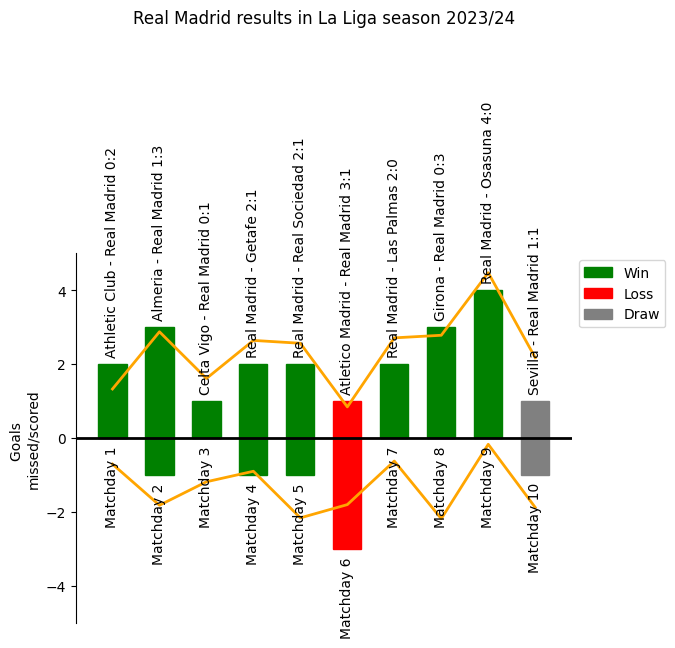

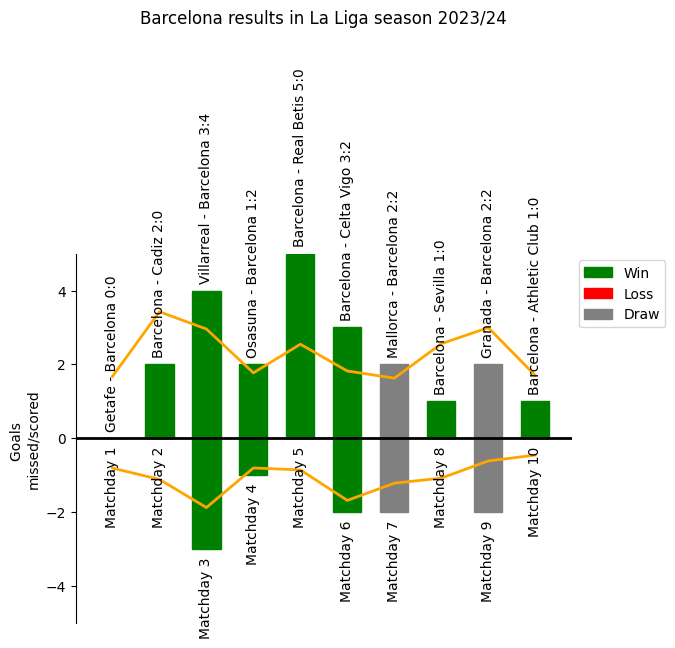

In [40]:
plot_matches_history(result_rma_df, 'Real Madrid')
plot_matches_history(result_bar_df, 'Barcelona')